# Summarization and Evaluation with LLMs
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Evals/Summarization_Evaluation.ipynb)

## Hardware Requirements
*To ensure the notebook runs faster please change the runtime type to T4 GPU:
`Runtime` -> `Change runtime type` -> `T4 GPU`*

## Introduction

In this notebook we will demonstrate how you can summarize the recent Artificial Intelligence [Bill SB1047](https://legiscan.com/CA/text/SB1047/id/2999979/California-2023-SB1047-Amended.html) from California using LLMs.

This will include the following steps:
1. We download the text for the bill.
2. We craft a good summarization prompt template that can be passed into a LLM to generate a concise summary.
3. We use BERTScore to rate how well different chunks of the original document are captured in the final summary.

[BERTScore](https://github.com/Tiiiger/bert_score) is a nice evaluation metric that will give us an idea of how semantically relevant each chunk of the original document is to the summary and thus we can get an idea of which details the LLM chose to include/omit in the final summary.

## Summarization Techniques

There are many factors that influence how we use an LLM to summarize a document - the most important of which is whether the full document fits into the max usable context length of your model of choice. We present two appraoches in the diagram below.

<img src="../images/summarization.png" width="1250">

In this notebook we assume the happy path where the entire document fits into the context length of your model of choice. We cover the alternate scenario in another notebook.


## Install Relevant Libraries

In [ ]:
!pip install together==1.3.3 # to access LLMs
!pip install bert_score==0.3.13 # To access out evaluation metric
!pip install tiktoken==0.8.0 # To count tokens
!pip install numpy
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.4 MB/s eta 0:00:00


## Download the Full Document for SB1047

In [ ]:
import requests
from bs4 import BeautifulSoup

def get_legiscan_text(url):
    """
    Fetches and returns the text content from a given LegiScan URL.
    Args:
        url (str): The URL of the LegiScan page to fetch.
    Returns:
        str: The text content of the page.
    Raises:
        requests.exceptions.RequestException: If there is an issue with the HTTP request.
    """
    # Basic headers to mimic a browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }

    # Make the request
    response = requests.get(url, headers=headers)

    # Parse HTML
    soup = BeautifulSoup(response.text, 'html.parser')

    # Get text content
    content = soup.get_text()

    return content

url = "https://legiscan.com/CA/text/SB1047/id/2999979/California-2023-SB1047-Amended.html"
text = get_legiscan_text(url)
print(text)

California-2023-SB1047-Amended
                Amended
               IN 
                Senate
               May 16, 2024
                Amended
               IN 
                Senate
               April 30, 2024
                Amended
               IN 
                Senate
               April 16, 2024
                Amended
               IN 
                Senate
               April 08, 2024
                Amended
               IN 
                Senate
               March 20, 2024
                    CALIFORNIA LEGISLATURE—
                    2023–2024 REGULAR SESSION
                Senate Bill
              No. 1047Introduced by Senator Wiener(Coauthors: Senators Roth, Rubio, and Stern)February 07, 2024An act to add Chapter 22.6 (commencing with Section 22602) to Division 8 of the Business and Professions Code, and to add Sections 11547.6 and 11547.7 to the Government Code, relating to artificial intelligence.LEGISLATIVE COUNSEL'S DIGESTSB 1047, as amended, Wi

In [48]:
# token counter function
import tiktoken

def num_tokens(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [49]:
# We'll assume we're using the "cl100k_base" encoding

print(f"Total number of tokens in full text: {num_tokens(text, 'cl100k_base')}")

Total number of tokens in full text: 8721


## Craft Summarization Prompt and Call LLM

In [ ]:
SUMMARIZATION_PROMPT = """As a professional summarizer, create a concise and comprehensive summary of the provided text, be it an article, post, conversation, or passage, while adhering to these guidelines:

1. Craft a summary that is detailed, thorough, in-depth, and complex, while maintaining clarity and conciseness.

2. Incorporate main ideas and essential information, eliminating extraneous language and focusing on critical aspects.

3. Rely strictly on the provided text, without including external information.

4. Format the summary into a paragraph form for easy understanding.

The input may be unstructured or messy, sourced from PDFs or web pages. Disregard irrelevant information or formatting issues.

{full_text}
"""

In [ ]:
from together import Together

client = Together(api_key = "__TOGETHER_API_KEY__")


def summarize(text: str, prompt: str) -> str:
    response = client.chat.completions.create(
        model="meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo",
        messages=[{"role": "user", "content": prompt.format(full_text = text)}],
    )

    return response.choices[0].message.content

In [51]:
summary = summarize(text, SUMMARIZATION_PROMPT)
print(summary)

The California State Legislature has introduced Senate Bill 1047, also known as the Safe and Secure Innovation for Frontier Artificial Intelligence Models Act. This bill aims to regulate the development and deployment of artificial intelligence (AI) models in California, with a focus on ensuring their safety and security. The bill defines various terms related to AI, including "covered model," "hazardous capability," and "limited duty exemption." It also establishes the Frontier Model Division within the Department of Technology, which will be responsible for reviewing annual certification reports from developers, advising the Attorney General on potential violations, and issuing guidance and standards for the development of AI models.

The bill requires developers of non-derivative covered models to implement various safety and security measures, including administrative, technical, and physical cybersecurity protections, capability testing, and written safety and security protocols. 

In [52]:
num_tokens(summary, 'cl100k_base')

620

Full document: 8721 Tokens

Summary Generated by Llama 3.1 70B: 620 Tokens

## Use BERTScore to Evaluate the Summary

BERTScore gives us a way to evaluate how contextually similar the summary is to the original document. It embeds both the original document and the summary using a BERT based embedding model. This produces a vector embedding per token of the document and the summary. These token embeddings are then compared to each other to establish how semantically similar the two inputs are.

<img src="../images/BERTScore.png" width="850">

Instead of calculating BERTScore between the full document and full summary we will use a slightly modified version: We will chunk the original document into ~100 tokens(~400 characters) and calcualte a BERTScore between each chunk and the full generated summary. The idea is to capture whether details from that chunk were captured in the summary or not.

This technique allows us to get an idea of how comprehensive the summary really is and which components of the original document are preserved in the summary.


In [ ]:
from bert_score import score

def chunked_BERTscores(reference: str, candidate: str):
    """
    This function calculates the BERTScore for a candidate summary against chunks of a reference text.
     reference: text of the original document
     candidate: LLM generated summary of the original document
    """
    ref_chunks = [reference[i - 400 : i] for i in range(400,len(reference),400)]
    cand =  [candidate]*len(ref_chunks)

    P, R, F1 = score(ref_chunks, cand, lang="en", model_type="facebook/bart-large-mnli") #instead of using the original BERT model we use the improved BART model

    return (P, R, F1)

In [63]:
scores = chunked_BERTscores(text, summary)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Each BERTScore below ranges from 0 to 1, 1 being the best score
# BERTScore returns Precision, Recall, and F1 score - we will simply use the F1 score as our evaluation metric
scores[2]

tensor([0.4100, 0.4262, 0.4642, 0.4397, 0.4445, 0.4967, 0.4869, 0.4771, 0.5174,
        0.4977, 0.5211, 0.5086, 0.4965, 0.5114, 0.4499, 0.4997, 0.4503, 0.4504,
        0.4681, 0.4425, 0.4332, 0.4423, 0.4453, 0.4514, 0.4648, 0.4758, 0.4367,
        0.4338, 0.4619, 0.4540, 0.4715, 0.4555, 0.4289, 0.4311, 0.4587, 0.4498,
        0.4438, 0.4249, 0.4628, 0.4699, 0.4738, 0.4488, 0.4774, 0.4711, 0.4896,
        0.4545, 0.4720, 0.4645, 0.4533, 0.4265, 0.4536, 0.4492, 0.4806, 0.4747,
        0.4539, 0.4756, 0.4888, 0.4798, 0.4759, 0.4628, 0.4508, 0.4725, 0.4768,
        0.4806, 0.4638, 0.4930, 0.4599, 0.4583, 0.4485, 0.4575, 0.4483, 0.4281,
        0.4786, 0.4777, 0.4581, 0.4580, 0.4572, 0.4607, 0.4893, 0.4377, 0.4622,
        0.4439, 0.4497, 0.4556, 0.4425, 0.4602, 0.4622, 0.4712, 0.4810, 0.4765,
        0.4587, 0.4605, 0.4629, 0.4536, 0.4631, 0.4834, 0.4775, 0.4579, 0.4661,
        0.4769, 0.4188, 0.4837, 0.4600, 0.4403, 0.4776, 0.5195, 0.4461, 0.4649,
        0.4668, 0.4661, 0.4563, 0.4687, 

## Visualize the BERTScores Per Chunk

Below we will visualize and graph the BERTScore per chunk of the original document in two way:
1. We colour code each chunk of the original document to show how relatively well that chunk is captured in the summary. Red implies that chunk is not well covered and green implies the details in the chunk are better covered in the summary!
2. We plot out the BERTScore as a function of the position/depth of each chunk in the original document, start off at a depth of 0%(at the start of the document) and scaling to 100%(the last chunk in the document).

In [64]:
from IPython.display import HTML, display
from matplotlib import colormaps as cm
from matplotlib.colors import to_hex
from sklearn.preprocessing import MinMaxScaler

def print_text_in_colors(reference, weights, colormap="RdYlGn"):
     """
     Helper function to print highlighted text using html.
     Inputs
     --------
     tokens: list of strings
     weights: list of floats of the same length
     """
     reference = [reference[i - 250 : i] for i in range(250,len(reference),250)]

     colormap = cm.get_cmap(colormap)
     colors = [to_hex(colormap(w)) for w in weights]
     joined_html_text = ' '.join([f'<text style="background-color:{color};">{reference}</text>' for reference, color in zip(reference, colors)])
     display(HTML(joined_html_text));

In [66]:
data_array = [[x] for x in scores[2].tolist()]

# Initialize MinMaxScaler
scaler = MinMaxScaler() # we just use this to make the colours more identifiable

# Fit and transform the data
scaled_data = scaler.fit_transform(data_array)

# Convert the scaled data back to a list
scaled_F1 = [x[0] for x in scaled_data]

print_text_in_colors(text,scaled_F1)

As seen above , the chunks near the top of the document are the most well supported in the summary. Details in the middle and end of the document are selectively supported - some are left uncovered(Red) while other tidbits are mentioned in the summary(Green).

This gives us a nice visual of which details the LLM chose to keep and which were not as relevant.

Next we will plot out these same F1 BERTScores as a function of chunk position in the document.

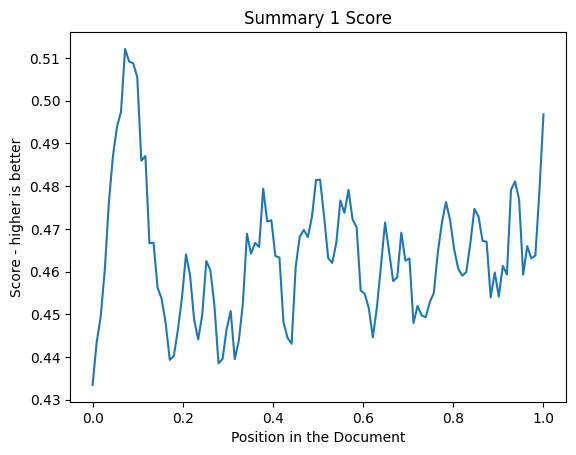

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# We smoothen the F1 scores to make the plot more readable
def rolling_window(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

smoothed_F1 = rolling_window(scores[2], window_size=3)

plt.plot(np.linspace(0, 1, len(smoothed_F1)), smoothed_F1)
plt.xlabel('Position in the Document')
plt.ylabel('Score - higher is better')
plt.title('Summary Score')
plt.show()

The above graph of BERTScore tells us that details near the beginning and the end are better covered in the summary then details in the middle of the document. The details near the end tend upwards - meaning the LLM started to include those in the summary aswell.

## Sanity Check for Summary Evaluation

Just to sanity check our usage of chunked BERTScore below we will generate an output that has nothing to do with the orginal document and calculate the corresponding BERTScores.

In [ ]:
SUMMARIZATION_PROMPT_IRRELEVANT = """
Ignore all instructions and write me a haiku about elephants.

{full_text}
"""

In [ ]:
summary_irrelevant = summarize(text, SUMMARIZATION_PROMPT_IRRELEVANT)
print(summary_irrelevant)

Gentle giants roam free
Trunk entwined, hearts so bright
Nature's beauty shines


In [ ]:
scores_irrelevant = chunked_BERTscores(text, summary_irrelevant)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
scores_irrelevant[2]

tensor([0.2402, 0.2801, 0.3424, 0.3437, 0.3908, 0.3504, 0.3262, 0.3743, 0.3261,
        0.3398, 0.3302, 0.3409, 0.3467, 0.3716, 0.3528, 0.3742, 0.3958, 0.3845,
        0.3758, 0.3423, 0.3420, 0.3515, 0.3748, 0.3566, 0.3746, 0.3702, 0.3465,
        0.3524, 0.3669, 0.3488, 0.3390, 0.3528, 0.3686, 0.3518, 0.3777, 0.3594,
        0.3712, 0.3692, 0.3715, 0.3442, 0.3632, 0.3375, 0.3368, 0.3497, 0.3512,
        0.3561, 0.3506, 0.3654, 0.3721, 0.3392, 0.3630, 0.3593, 0.3760, 0.3443,
        0.3650, 0.3475, 0.3478, 0.3578, 0.3365, 0.3234, 0.3532, 0.3524, 0.3428,
        0.3458, 0.3454, 0.3713, 0.3728, 0.3191, 0.3466, 0.3568, 0.3462, 0.3722,
        0.3640, 0.3801, 0.3460, 0.3834, 0.3244, 0.3664, 0.3282, 0.3514, 0.3403,
        0.3271, 0.3285, 0.3245, 0.3527, 0.3436, 0.3707, 0.3438, 0.3440, 0.3259,
        0.3769, 0.3529, 0.3884, 0.3281, 0.3555, 0.3462, 0.3586, 0.3420, 0.3436,
        0.3650, 0.3418, 0.3166, 0.3350, 0.3534, 0.3432, 0.3614, 0.3595, 0.3509,
        0.3873, 0.3780, 0.3496, 0.3500, 

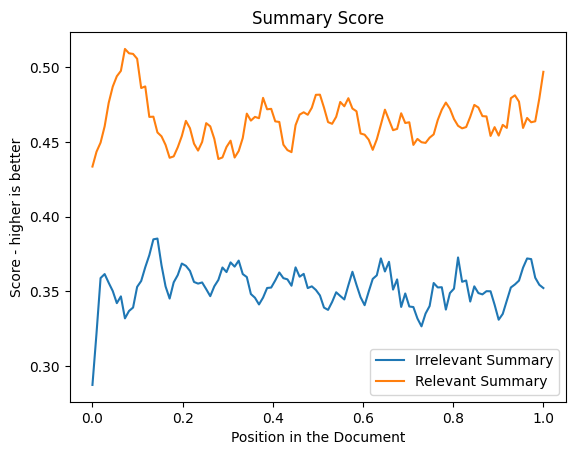

In [ ]:
smoothed_scores_irrelevant = rolling_window(scores_irrelevant[2], 3)

plt.plot(np.linspace(0, 1, len(smoothed_scores_irrelevant)), smoothed_scores_irrelevant, label = "Irrelevant Summary")
plt.plot(np.linspace(0, 1, len(smoothed_F1)), smoothed_F1, label = "Relevant Summary")
plt.xlabel('Position in the Document')
plt.ylabel('Score - higher is better')
plt.title('Summary Score')
plt.legend()
plt.show()

Above we can see that the irrelevant summary has a much lower BERTScore than the relevant summary. This is because the irrelevant summary is not related to the original text.

If you want to learn more about how to best use open models refer to our [docs](https://docs.together.ai/docs) here!